In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import g4ppyy as g4
from g4ppyy.SI import mm, cm, m, eV, MeV, GeV, twopi, deg

import random

gRunManager = g4.gRunManager
gVisExecutive = g4.gVisExecutive

[G4PPYY] : Geant4 Python wrapper for CPPYY
[G4PPYY] : Author: P. Stowell (p.stowell@sheffield.ac.uk)
[G4PPYY] :         R. Foster
[G4PPYY] : Loading G4 Modules.
[G4PPYY] : G4PREFIX : /app/geant4-v11.2.2/install
[G4PPYY] : G4VERSION : 11.2.2
[G4PPYY] : Module loading complete.

**************************************************************
 Geant4 version Name: geant4-11-02-patch-02 [MT]   (21-June-2024)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

[G4PPYY] : Imported all definitions.


In [2]:
class custom_generator(g4.G4VUserPrimaryGeneratorAction):
    "Moderated Cf252 Generator"
    def __init__(self):
        super().__init__()
        self.particle = g4.G4Neutron.Definition()
        self.particleGun = g4.G4ParticleGun()
        self.particleGun.SetParticleDefinition(self.particle)
        self.particleGun.SetParticleMomentumDirection(g4.G4ThreeVector(1, 0, 0))
        self.particleGun.SetNumberOfParticles(1)  
        self.particleGun.SetParticleTime(0)

    def GeneratePrimaries(self, anEvent):
        energy = 14 * MeV #beam_energy
        self.particleGun.SetParticlePosition(g4.G4ThreeVector(-40*cm,-1*cm + 5*cm*random.random(),-1*cm + 5*cm*random.random()))
        self.particleGun.SetParticleEnergy(energy)  
        self.particleGun.GeneratePrimaryVertex(anEvent)

class neutron_tracker(g4.G4VSensitiveDetector):

    def __init__(self, name):
        super().__init__(name)
        
        self.neutron_event = {
            "eid": [],
            "edep": [],
            "x": [],
            "y": [],
            "z": []        
        }
                
    def ProcessHits(self, aStep, ROhist):
        
        pdg = (aStep.GetTrack().GetParticleDefinition().GetPDGEncoding())
        if not (pdg == 2112): return 0

        eid = int(gRunManager.GetCurrentEvent().GetEventID())

        self.neutron_event["eid"].append( eid )
        
        pos = aStep.GetPreStepPoint().GetPosition() 
        dirs = aStep.GetTrack().GetMomentumDirection() 
        ek = aStep.GetPreStepPoint().GetTotalEnergy() 

        self.neutron_event["edep"].append(aStep.GetTotalEnergyDeposit())
        self.neutron_event["x"].append(pos.x())
        self.neutron_event["y"].append(pos.y())
        self.neutron_event["z"].append(pos.z())
        
        aStep.GetTrack().SetTrackStatus(g4.G4TrackStatus.fStopAndKill)

        return 1


class custom_world(g4.cppyy.gbl.G4VUserDetectorConstruction):         
    def BuildMaterials(self):
        # Material definitions
        self.water_mat = g4.gNistManager.FindOrBuildMaterial("G4_WATER")

    def BuildWorld(self):
        # Mother Box
        self.world = g4.builder.build_component("world", solid="box", x=5*m, y=5*m, z=5*m, material=self.water_mat, drawstyle="wireframe")

        # World Geometries        
        self.hdpe_outer   = g4.builder.build_component("shell", solid="tubs", rot=[90*deg, 0.0, 0.0], rmax=22*cm, z=1.2*m/2, mother=self.world, material="G4_POLYETHYLENE", color=[0.0,0.0,1.0,0.8], drawstyle="solid")
        self.water_inner  = g4.builder.build_component("water", solid="tubs", rmax=18*cm, z=1.2*m/2, mother=self.hdpe_outer, material="G4_WATER", color=[0.5,0.5,1.0,0.1], drawstyle="solid")
        self.hdpe_endcap1 = g4.builder.build_component("cap1", solid="tubs", rmax=18*cm, z=1*cm, mother=self.water_inner, material="G4_POLYETHYLENE", color=[1.0,0.2,1.0,0.8], drawstyle="solid", pos=[0.0, 0.0, +1.2*m/2 - 1*cm])
        self.hdpe_endcap2 = g4.builder.build_component("cap2", solid="tubs", rmax=18*cm, z=1*cm, mother=self.water_inner, material="G4_POLYETHYLENE", color=[1.0,0.2,1.0,0.8], drawstyle="solid", pos=[0.0, 0.0, -1.2*m/2 + 1*cm])

        self.hdpe_endcap3 = g4.builder.build_component("cap3", solid="sphere", rmax=10*cm, z=10*cm, mother=self.world, material="G4_POLYETHYLENE", color=[1.0,0.1,1.0,0.8], drawstyle="solid", pos=[+2.0*m, 0.0, 0.0])
        self.hdpe_endcap4 = g4.builder.build_component("cap4", solid="box", x=30*cm, y=10*cm, z=10*cm, mother=self.world, material="G4_POLYETHYLENE", color=[1.0,1.0,0.1,0.8], drawstyle="solid", pos=[0.0*m, +1.0*m, -1.2*m/2 + 1*cm])

    def BuildDetectors(self):
        # Sensitive Volume Definitions
        self.hdpe_det = neutron_tracker("hdpe_det")
        self.world_det = neutron_tracker("world_det")
        
        self.world.GetLogicalVolume().SetSensitiveDetector(self.world_det)
        self.hdpe_outer.GetLogicalVolume().SetSensitiveDetector(self.hdpe_det)

    def Construct(self):
        self.BuildMaterials()
        self.BuildWorld()
        self.BuildDetectors()
        
        # Return the mother
        return self.world # top mother volume


In [3]:
# In [4]:
# Add Physics List
physics = g4.QGSP_BERT()
gRunManager.SetUserInitialization(physics)

# Add a World
detector = custom_world()
gRunManager.SetUserInitialization(detector)

# Add a Generator
gen = custom_generator()
gRunManager.SetUserAction(gen)

g4.run.add_default_actions(gRunManager)

gRunManager.Initialize()

<<< Geant4 Physics List simulation engine: QGSP_BERT


 hInelastic QGSP_BERT  Thresholds: 
    1) between BERT  and FTF/P over the interval 3 to 6 GeV. 
    2) between FTF/P and QGS/P over the interval 12 to 25 GeV. 
  -- quasiElastic: 1 for QGS  and 0 for FTF
### Adding tracking cuts for neutron  TimeCut(ns)= 10000  KinEnergyCut(MeV)= 0


In [4]:
# g4.run.create_visualization(gRunManager)

g4.mc.vis.open("K3DJupyter","600x600-0+0")
g4.mc.vis.drawVolume()
g4.mc.vis.viewer.set.autoRefresh(True)
g4.mc.vis.scene.add.trajectories("rich")
g4.mc.vis.modeling.trajectories.create.drawByCharge()
g4.mc.run.beamOn(1000)
g4.mc.vis.viewer.refresh()




======                 Electromagnetic Physics Parameters      ========
LPM effect enabled                                 1
Enable creation and use of sampling tables         0
Apply cuts on all EM processes                     0
Use combined TransportationWithMsc                 Disabled
Use general process                                1
Enable linear polarisation for gamma               0
Enable photoeffect sampling below K-shell          1
Enable sampling of quantum entanglement            0
X-section factor for integral approach             0.8
Min kinetic energy for tables                      100 eV 
Max kinetic energy for tables                      100 TeV
Number of bins per decade of a table               7
Verbose level                                      1
Verbose level for worker thread                    0
Bremsstrahlung energy threshold above which 
  primary e+- is added to the list of secondary    100 TeV
Bremsstrahlung energy threshold above which primary
  muon/ha

Output()

50000 22668 50000


/usr/local/lib/python3.9/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "uint32" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


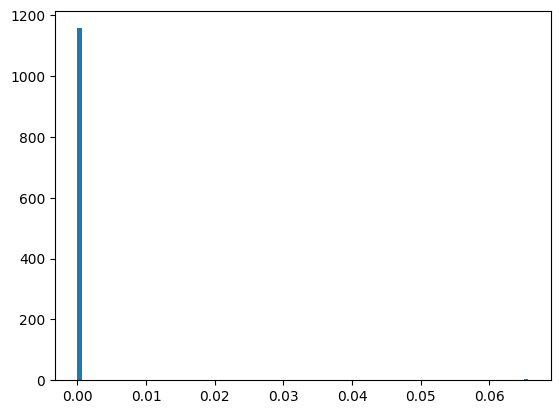

In [5]:
plt.hist(detector.world_det.neutron_event["edep"], bins=100)
plt.show()